<a href="https://colab.research.google.com/github/reitezuz/notebooks-for-NES2-2024/blob/main/lecture_11/simple_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series prediction - Jena Climate Dataset

Inspired by: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter10_dl-for-timeseries.ipynb

# Jena Climate Dataset
The dataset contains meteorological data recorded in Jena, Germany, from 2009 to 2016. Measurement frequency: Every 10 minutes. It is suitable for time series analysis and weather prediction.
- File type: CSV (compressed in a ZIP file).

**Variables:**
- `Datetime` - Date and time of measurement.
- `Temperature (°C)` - Temperature.
- `Pressure (hPa)` - Atmospheric pressure.
- `Humidity (%)` - Relative humidity.
- `Wind speed (m/s)` - Wind speed.
- `Wind direction (°)` - Wind direction in degrees.
- `Radiation (W/m²)` - Solar radiation intensity.
- ...

**Uses:**
- Temperature or other meteorological variable prediction.
- Seasonal and trend analysis in time series data.

**Source:**
Dataset download: [jena_climate_2009_2016.csv.zip](https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip)

https://www.kaggle.com/datasets/mnassrib/jena-climate


1. Download the zip file with the data
2. Extract the zip file

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

import os
# Clean up by removing the downloaded zip file
os.remove("jena_climate_2009_2016.csv.zip")


'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


FileNotFoundError: [WinError 2] Systém nemůže nalézt uvedený soubor: 'jena_climate_2009_2016.csv.zip'

## Observe the data

In [24]:
import pandas as pd
import numpy as np
import os

file_path = "jena_climate_2009_2016.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Extract header and number of rows using pandas
header = list(df.columns)
num_rows = len(df)

# Extract 'Temperature (°C)' column into temperature array
temperature = df['T (degC)'].values

# Create raw_data array (excluding the Date Time column)
raw_data = df.drop(columns=['Date Time']).values


print("Header:", header)
print("Number of columns:", len(header))
print("Number of rows:", num_rows)
print("Temperature array shape:", temperature.shape)
print("Raw data array shape:", raw_data.shape)

# Example: Display first few rows of the DataFrame
print(df.head())



Header: ['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']
Number of columns: 15
Number of rows: 420451
Temperature array shape: (420451,)
Raw data array shape: (420451, 14)
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.

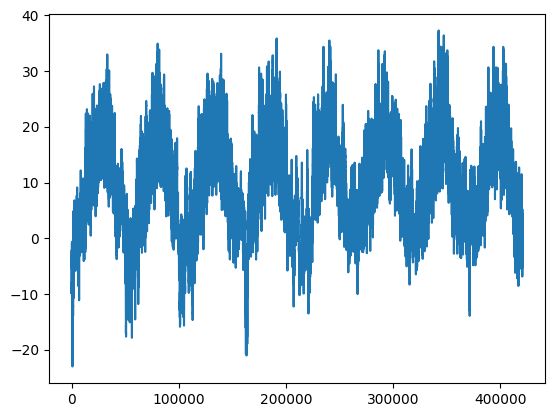

In [25]:
# Plotting the temperature timeseries
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

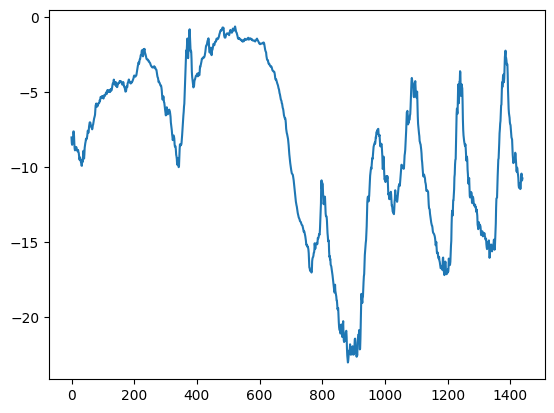

In [26]:
# Plotting the first 10 days of the temperature timeseries (24*6 = 144 points per day)
plt.plot(range(1440), temperature[:1440])

## Simple Example: Dataset for time series

- create a simple timeseries training set from an array:
- https://keras.io/api/data_loading/timeseries/

In [27]:
import numpy as np
import keras

int_sequence = np.arange(10)
print(int_sequence)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    print("")
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))


[0 1 2 3 4 5 6 7 8 9]

[0, 1, 2] 3
[1, 2, 3] 4

[2, 3, 4] 5
[3, 4, 5] 6

[4, 5, 6] 7


## Our task

- We will use only data measured once per hour instead of all data (measured every 10 minutes).
- Based on the values from the previous 5 days, we will predict the temperature 24 hours ahead.
   - 24 points per day, 120 points in 5 days

## Prepare the data

In [28]:
import numpy as np
import keras

# Training, validation and testing data
num_train_samples = int(0.5 * len(raw_data)) # 50 % training data
num_val_samples = int(0.25 * len(raw_data))  # 25 % validation and testing data
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

# Normalize the data:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

# Create the training, validation and testing data sets:
sampling_rate = 6        # we will use each 6th sample (1 per hour)
sequence_length = 120    # we will use data from 120 hours (5 days)
delay = sampling_rate * (sequence_length + 24 - 1) # target: value 24 hours after the end of sequence
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    #shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)


for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
print("Number of batches:", len(train_dataset))

samples shape: (256, 120, 14)
targets shape: (256,)
Number of batches: 819


In [29]:
# Data frame for results
import pandas as pd

columns = ["Model Name", "Details", "Train MAE", "Val MAE", "Test MAE"]
results_df = pd.DataFrame(columns=columns)

## Compute the common-sense baseline MAE
- predict the temperature 24 hours ago

In [30]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

train_loss = evaluate_naive_method(train_dataset)
val_loss = evaluate_naive_method(val_dataset)
test_loss = evaluate_naive_method(test_dataset)
print(f"Training MAE: {train_loss:.2f}")
print(f"Validation MAE: {val_loss:.2f}")
print(f"Test MAE: {test_loss:.2f}")

# Add results to the dataframe:
new_entry = {
    "Model Name" : "Baseline",
    "Details" : "Previous day",
    "Train MAE" : train_loss,
    "Val MAE" : val_loss,
    "Test MAE" : test_loss,
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
model_dir = "./models/"
if not os.path.exists(os.path.dirname(model_dir)):
    os.makedirs(os.path.dirname(model_dir))
results_df.to_csv("models/jena_results.csv", index=False)

Training MAE: 2.69
Validation MAE: 2.44
Test MAE: 2.62
Results:
  Model Name       Details  Train MAE   Val MAE  Test MAE
0   Baseline  Previous day   2.691644  2.441733  2.622036


C:\Users\zuzka\AppData\Local\Temp\ipykernel_25648\1770437177.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)


## Define and train the model: a simple MLP

In [31]:
# flattten the data:

import tensorflow as tf

def reshape_samples(samples, targets):
    batch_size = tf.shape(samples)[0] # Use tf.shape to get the dynamic batch size
    reshaped_samples = tf.reshape(samples, (batch_size, -1))  # Flatten the samples
    return reshaped_samples, targets

train_dataset_fl = train_dataset.map(reshape_samples)
val_dataset_fl = val_dataset.map(reshape_samples)
test_dataset_fl = test_dataset.map(reshape_samples)

for samples, targets in train_dataset_fl:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
print("Number of batches:", len(train_dataset_fl))

samples shape: (256, 1680)
targets shape: (256,)
Number of batches: 819


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │        26,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,913 (105.13 KB)

 Trainable params: 26,913 (105.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - loss: 30.3080 - mae: 4.1118 - val_loss: 11.0798 - val_mae: 2.6169
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 10.1762 - mae: 2.5170 - val_loss: 10.7056 - val_mae: 2.5761
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 9.4872 - mae: 2.4285 - val_loss: 10.4169 - val_mae: 2.5538
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 9.0278 - mae: 2.3682 - val_loss: 10.5741 - val_mae: 2.5753
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - loss: 8.6389 - mae: 2.3162 - val_loss: 10.4839 - val_mae: 2.5589
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 27s 33ms/step - loss: 8.3496 - mae: 2.2790 - val_loss: 10.5381 - val_mae: 2.5682
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 8.0902 - mae: 2.2405 - val_loss: 10.6174 - val_mae: 2.5847
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 7.8959 - mae: 2.2135 - val_loss: 10.5544 - val_mae: 2.5716
Epoch 9/10
819/819 ━━━━━━━━━━━

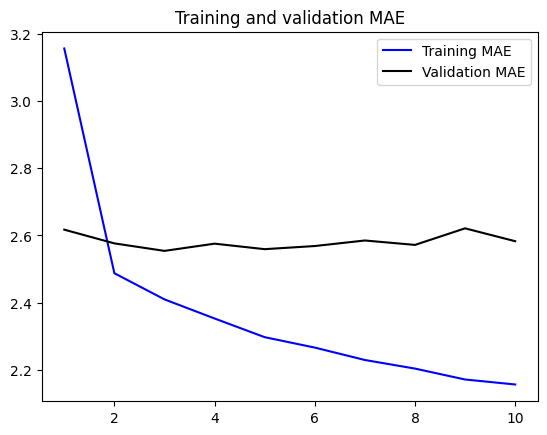

In [32]:
# train the model
import keras
from keras import layers

# Define model architecture
inputs = keras.Input(shape=(sequence_length * raw_data.shape[-1],))
#x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("models/jena_dense.keras",
                                    save_best_only=True)
]

# Set model parameters
model.compile(optimizer= keras.optimizers.Adam(), # SGD, Adam, RMSProp
              loss= keras.losses.MeanSquaredError(),
              metrics= [keras.metrics.MeanAbsoluteError(name="mae")])

# Train the model
history = model.fit(train_dataset_fl,
                    epochs=10,
                    validation_data=val_dataset_fl,
                    callbacks=callbacks)

model = keras.models.load_model("models/jena_dense.keras")

# Evaluate the model on the test set
val_loss= model.evaluate(val_dataset_fl)
test_loss = model.evaluate(test_dataset_fl)
train_loss = model.evaluate(train_dataset_fl)
print(f"Train      MAE: {train_loss[1]:.2f}")
print(f"Validation MAE: {val_loss[1]:.2f}")
print(f"Test       MAE: {test_loss[1]:.2f}")


# Add results to the dataframe:
new_entry = {
    "Model Name" : "Simple MLP",
    "Details" : 16,
    "Train MAE" : train_loss[1],
    "Val MAE" : val_loss[1],
    "Test MAE" : test_loss[1],
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b", label="Training MAE")
plt.plot(epochs, val_loss, "k", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [36]:
import matplotlib.pyplot as plt

def plot_predictions(dataset, model, num_samples=24, start_index=0):
    """Plots predicted vs. real outputs starting from a specific index."""
    preds_list = []
    targets_list = []

    samples_seen = 0
    total_seen = 0

    for samples, targets in dataset:
        batch_size = samples.shape[0]
        if total_seen + batch_size <= start_index:
            total_seen += batch_size
            continue

        batch_start_index = max(0, start_index - total_seen)

        preds = model.predict(samples, verbose = 0)
        preds_list.extend(preds.reshape(-1)[batch_start_index:])
        targets_list.extend(targets[batch_start_index:])
        
        samples_seen += batch_size - batch_start_index
        total_seen += batch_size

        if samples_seen >= num_samples:
            break

    # Zkrácení na požadovaný počet vzorků
    preds_list = preds_list[:num_samples]
    targets_list = targets_list[:num_samples]

    plt.figure(figsize=(10, 3))
    plt.plot(targets_list, label='Real Values')
    plt.plot(preds_list, label='Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Temperature (°C)')
    plt.title('Predicted vs. Real Temperature')
    plt.legend()
    plt.show()


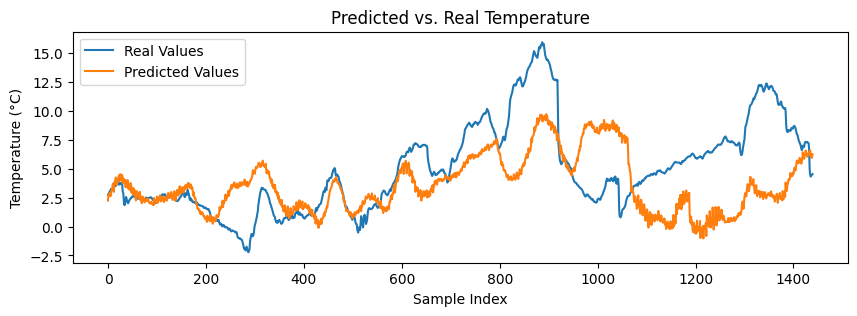

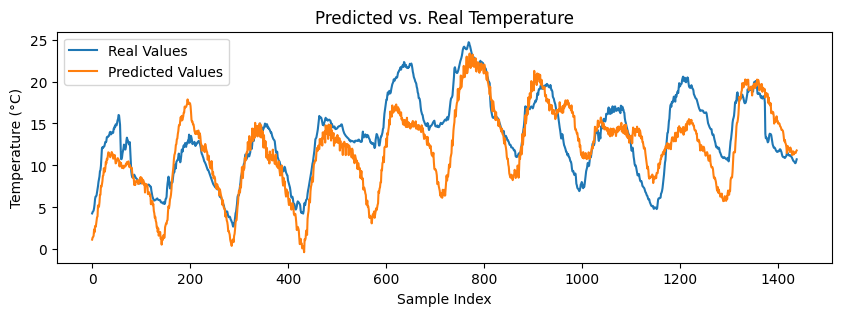

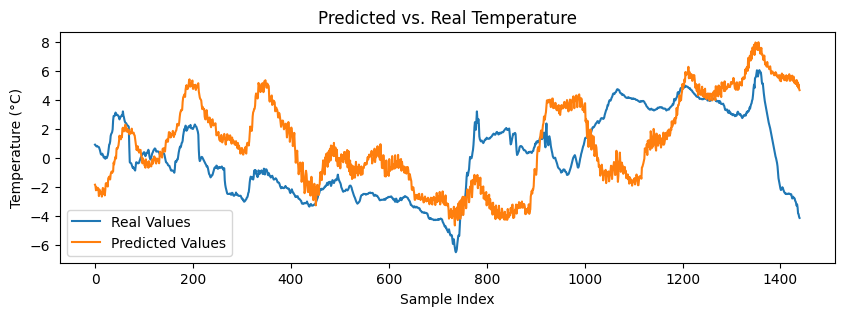

In [37]:
model = keras.models.load_model("models/jena_dense.keras")
for start_index in [24, 24*6*4*29, 24*6*1*29,]:
    plot_predictions(test_dataset_fl, model, 24*6*10, start_index)

##  A 1D convolutional model

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 97, 8)          │         2,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 48, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 37, 8)          │           776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 18, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 13, 8)          │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 8)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,873 (15.13 KB)

 Trainable params: 3,873 (15.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - loss: 35.7557 - mae: 4.5213 - val_loss: 14.2363 - val_mae: 2.9747
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - loss: 14.7321 - mae: 3.0484 - val_loss: 12.8539 - val_mae: 2.8168
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - loss: 12.8006 - mae: 2.8308 - val_loss: 13.0502 - val_mae: 2.8361
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - loss: 12.0281 - mae: 2.7449 - val_loss: 12.6159 - val_mae: 2.7998
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - loss: 11.4126 - mae: 2.6705 - val_loss: 12.6491 - val_mae: 2.8063
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - loss: 10.9690 - mae: 2.6206 - val_loss: 13.0346 - val_mae: 2.8595
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - loss: 10.6737 - mae: 2.5822 - val_loss: 12.4802 - val_mae: 2.7902
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - loss: 10.3499 - mae: 2.5438 - val_loss: 12.2413 - val_mae: 2.7590
Epoch 9/10
819/819 ━━━━━

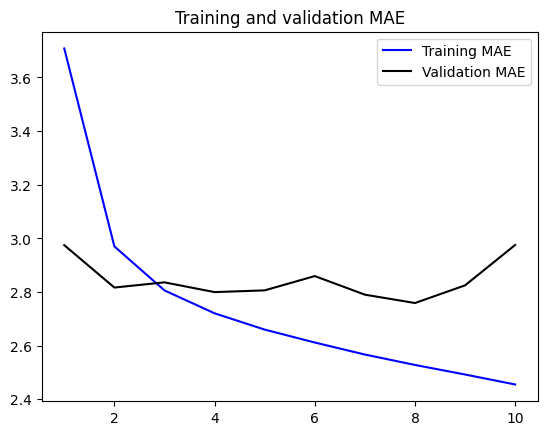

In [38]:
# Define model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

# Set model parameters
model.compile(optimizer= keras.optimizers.Adam(), # SGD, Adam, RMSProp
              loss= keras.losses.MeanSquaredError(),
              metrics= [keras.metrics.MeanAbsoluteError(name="mae")])

# Train the model
callbacks = [
    keras.callbacks.ModelCheckpoint("models/jena_conv.keras",
                                    save_best_only=True)
]

history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("models/jena_conv.keras")

# Evaluate the model on the test set
val_loss= model.evaluate(val_dataset)
test_loss = model.evaluate(test_dataset)
train_loss = model.evaluate(train_dataset)
print(f"Train      MAE: {train_loss[1]:.2f}")
print(f"Validation MAE: {val_loss[1]:.2f}")
print(f"Test       MAE: {test_loss[1]:.2f}")


# Add results to the dataframe:
new_entry = {
    "Model Name" : "Simple CNN",
    "Details" : "24 ",
    "Train MAE" : train_loss[1],
    "Val MAE" : val_loss[1],
    "Test MAE" : test_loss[1],
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b", label="Training MAE")
plt.plot(epochs, val_loss, "k", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

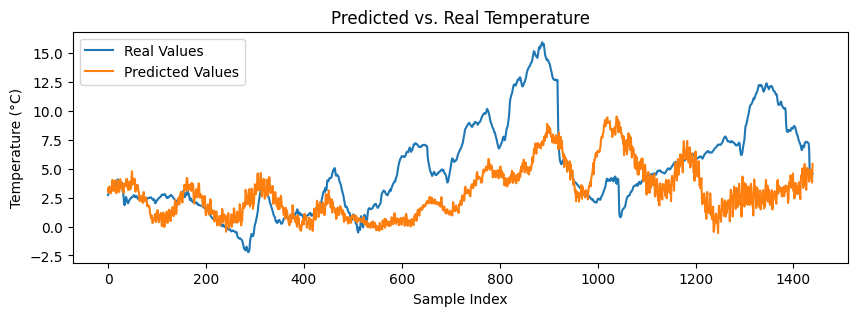

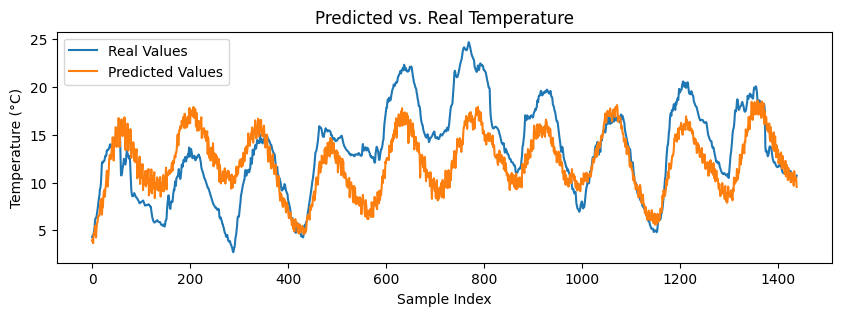

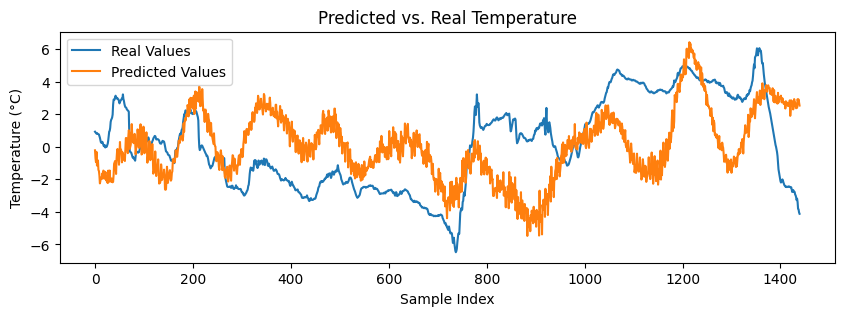

In [39]:
for start_index in [24, 24*6*4*29, 24*6*1*29,]:
    plot_predictions(test_dataset, model, 24*6*10, start_index)

# A simple LSTM-based model





Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,001 (7.82 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
818/819 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 83.4510 - mae: 7.0374

819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 99ms/step - loss: 83.3693 - mae: 7.0330 - val_loss: 18.8816 - val_mae: 3.2210
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 17.4580 - mae: 3.1434 - val_loss: 11.7500 - val_mae: 2.6137
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - loss: 11.9593 - mae: 2.6708 - val_loss: 10.2535 - val_mae: 2.4740
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 60ms/step - loss: 10.7008 - mae: 2.5480 - val_loss: 9.8003 - val_mae: 2.4283
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 58ms/step - loss: 10.4083 - mae: 2.5181 - val_loss: 9.5925 - val_mae: 2.3957
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - loss: 9.8208 - mae: 2.4452 - val_loss: 9.7748 - val_mae: 2.4137
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 59ms/step - loss: 9.6055 - mae: 2.4148 - val_loss: 9.6278 - val_mae: 2.3977
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - loss: 9.5356 - mae: 2.4037 - val_loss: 9.2711 - val_mae: 2.3709
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s

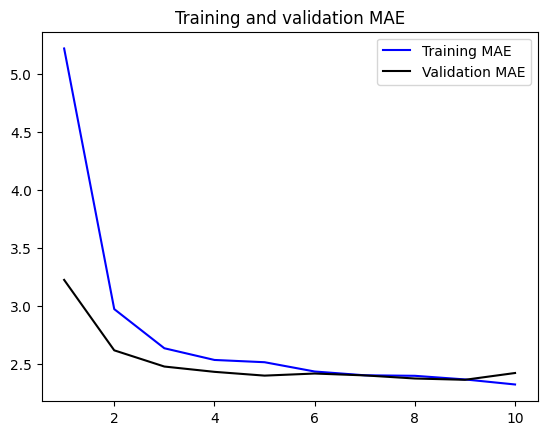

In [40]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()


callbacks = [
    keras.callbacks.ModelCheckpoint("models/jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("models/jena_lstm.keras")

# Evaluate the model on the test set
val_loss= model.evaluate(val_dataset)
test_loss = model.evaluate(test_dataset)
train_loss = model.evaluate(train_dataset)
print(f"Train      MAE: {train_loss[1]:.2f}")
print(f"Validation MAE: {val_loss[1]:.2f}")
print(f"Test       MAE: {test_loss[1]:.2f}")


# Add results to the dataframe:
new_entry = {
    "Model Name" : "Simple LSTM",
    "Details" : 16,
    "Train MAE" : train_loss[1],
    "Val MAE" : val_loss[1],
    "Test MAE" : test_loss[1],
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b", label="Training MAE")
plt.plot(epochs, val_loss, "k", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

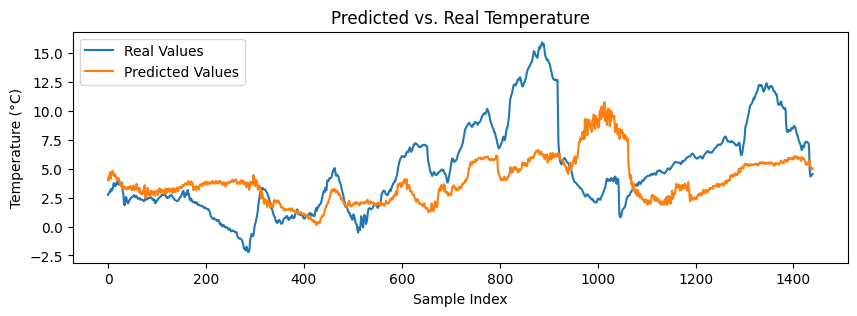

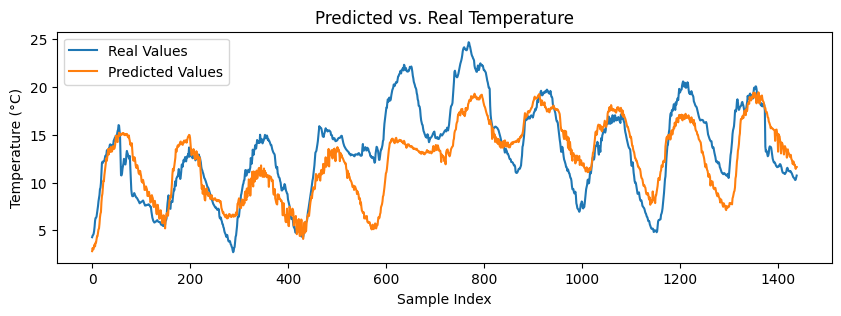

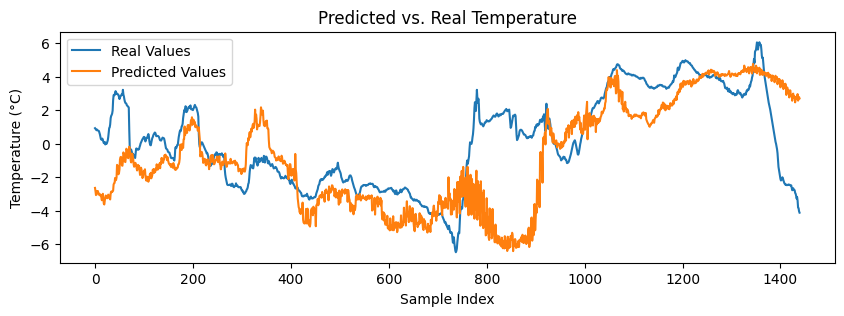

In [41]:
for start_index in [24, 24*6*4*29, 24*6*1*29,]:
    plot_predictions(test_dataset, model, 24*6*10, start_index)

## LSTM with dropout and gradient clipping

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,049 (23.63 KB)

 Trainable params: 6,049 (23.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 97ms/step - loss: 55.8637 - mae: 5.5495 - val_loss: 9.6378 - val_mae: 2.4128
Epoch 2/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 77s 93ms/step - loss: 15.4879 - mae: 3.0593 - val_loss: 9.2449 - val_mae: 2.3689
Epoch 3/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 85s 104ms/step - loss: 14.5942 - mae: 2.9644 - val_loss: 9.0173 - val_mae: 2.3335
Epoch 4/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 81s 99ms/step - loss: 14.0281 - mae: 2.9054 - val_loss: 8.9399 - val_mae: 2.3193
Epoch 5/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 75s 92ms/step - loss: 13.5115 - mae: 2.8526 - val_loss: 8.9689 - val_mae: 2.3221
Epoch 6/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 74s 91ms/step - loss: 13.1259 - mae: 2.8127 - val_loss: 9.0957 - val_mae: 2.3301
Epoch 7/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - loss: 12.8052 - mae: 2.7737 - val_loss: 8.8840 - val_mae: 2.3038
Epoch 8/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 101ms/step - loss: 12.6245 - mae: 2.7551 - val_loss: 8.8429 - val_mae: 2.2997
Epoch 9/30
819/819 ━━━━━━━━━━━

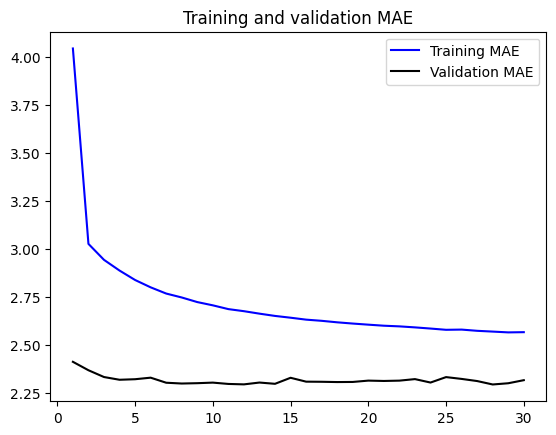

In [42]:
# Define model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs) # change 16 -> 32.
x = layers.Dropout(0.5)(x)                          # dropout layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("models/jena_lstm_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer=keras.optimizers.Adam(clipnorm=1.0),  # change
              loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=30, # change
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("models/jena_lstm_dropout.keras")

# Evaluate the model on the test set
val_loss= model.evaluate(val_dataset)
test_loss = model.evaluate(test_dataset)
train_loss = model.evaluate(train_dataset)
print(f"Train      MAE: {train_loss[1]:.2f}")
print(f"Validation MAE: {val_loss[1]:.2f}")
print(f"Test       MAE: {test_loss[1]:.2f}")


# Add results to the dataframe:
new_entry = {
    "Model Name" : "Regularized LSTM",
    "Details" : "dropout",
    "Train MAE" : train_loss[1],
    "Val MAE" : val_loss[1],
    "Test MAE" : test_loss[1],
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b", label="Training MAE")
plt.plot(epochs, val_loss, "k", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

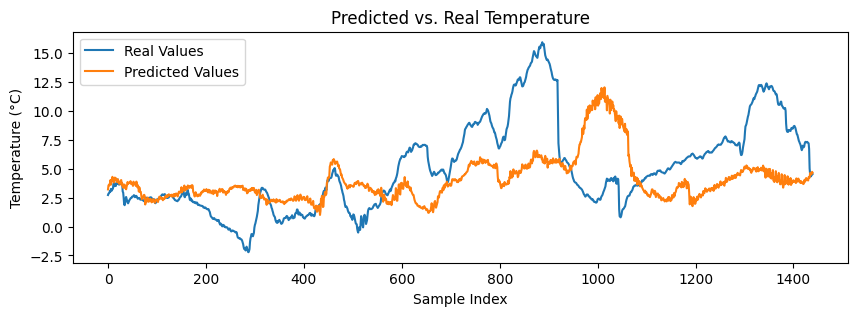

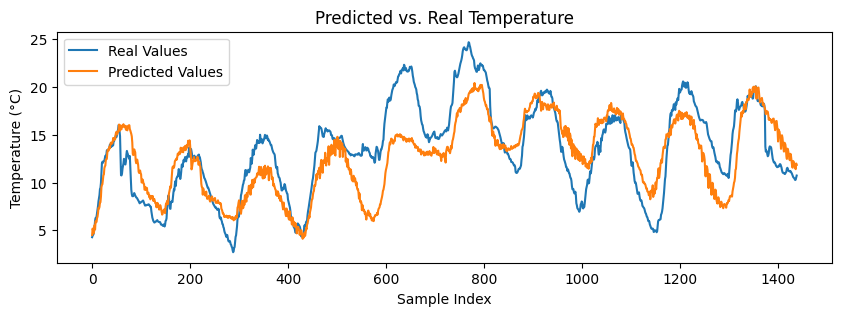

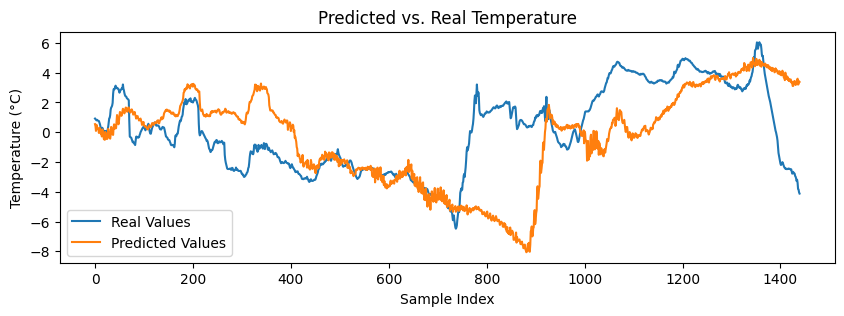

In [43]:
for start_index in [24, 24*6*4*29, 24*6*1*29,]:
    plot_predictions(test_dataset, model, 24*6*10, start_index)

In [53]:
print(results_df)

         Model Name       Details  Train MAE   Val MAE  Test MAE
0          Baseline  Previous day   2.691644  2.441733  2.622036
1        Simple MLP            16   2.349430  2.553793  2.669994
2        Simple CNN           24    2.497848  2.759038  2.987731
3       Simple LSTM            16   2.324639  2.359707  2.560501
4  Regularized LSTM       dropout   2.227868  2.295274  2.520931
5    Multilayer GRU       dropout   2.268909  2.299432  2.439442


In [ ]:
#results_df = results_df.drop(6, axis=0).reset_index(drop=True)

## GRU with more layers

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 120, 16)        │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,185 (12.44 KB)

 Trainable params: 3,185 (12.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


819/819 ━━━━━━━━━━━━━━━━━━━━ 93s 108ms/step - loss: 70.7597 - mae: 6.4263 - val_loss: 11.9110 - val_mae: 2.5865
Epoch 2/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 89s 109ms/step - loss: 13.5833 - mae: 2.8379 - val_loss: 9.2222 - val_mae: 2.3496
Epoch 3/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 88s 108ms/step - loss: 11.9848 - mae: 2.6837 - val_loss: 8.8916 - val_mae: 2.3119
Epoch 4/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 89s 108ms/step - loss: 11.5082 - mae: 2.6291 - val_loss: 8.9275 - val_mae: 2.3156
Epoch 5/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 89s 108ms/step - loss: 11.1313 - mae: 2.5881 - val_loss: 8.8370 - val_mae: 2.2994
Epoch 6/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 88s 107ms/step - loss: 10.7721 - mae: 2.5467 - val_loss: 9.0464 - val_mae: 2.3320
Epoch 7/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 89s 108ms/step - loss: 10.3234 - mae: 2.4986 - val_loss: 8.9107 - val_mae: 2.3087
Epoch 8/20
819/819 ━━━━━━━━━━━━━━━━━━━━ 88s 107ms/step - loss: 10.0338 - mae: 2.4650 - val_loss: 9.2795 - val_mae: 2.3558
Epoch 9/20
819/819 ━━━━━━━━━━━━━━━

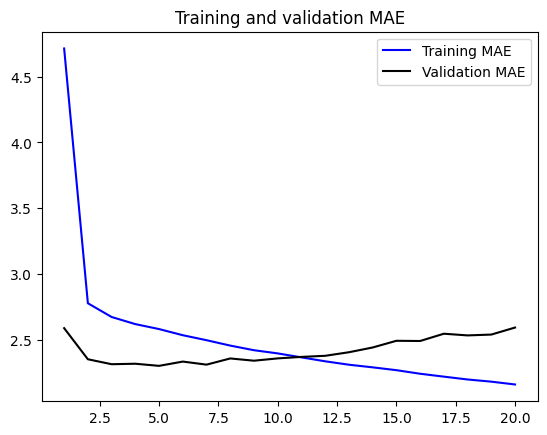

In [46]:
# Define model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16, return_sequences=True)(inputs)
x = layers.GRU(16)(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("models/jena_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer=keras.optimizers.Adam( clipnorm=1.0),  # change
              loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20, # change
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("models/jena_gru_dropout.keras")

# Evaluate the model on the test set
val_loss= model.evaluate(val_dataset)
test_loss = model.evaluate(test_dataset)
train_loss = model.evaluate(train_dataset)
print(f"Train      MAE: {train_loss[1]:.2f}")
print(f"Validation MAE: {val_loss[1]:.2f}")
print(f"Test       MAE: {test_loss[1]:.2f}")


# Add results to the dataframe:
new_entry = {
    "Model Name" : "Multilayer GRU",
    "Details" : "dropout",
    "Train MAE" : train_loss[1],
    "Val MAE" : val_loss[1],
    "Test MAE" : test_loss[1],
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b", label="Training MAE")
plt.plot(epochs, val_loss, "k", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

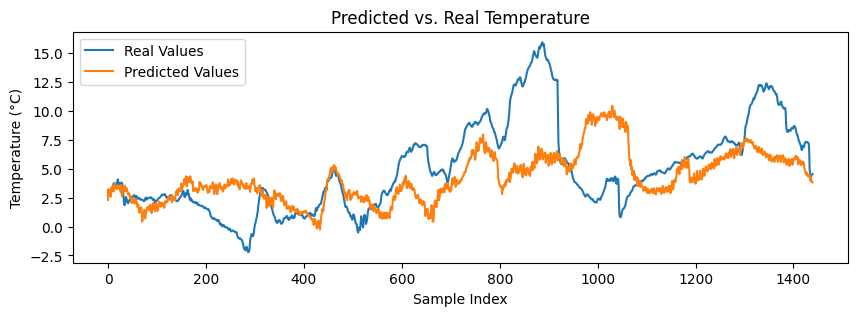

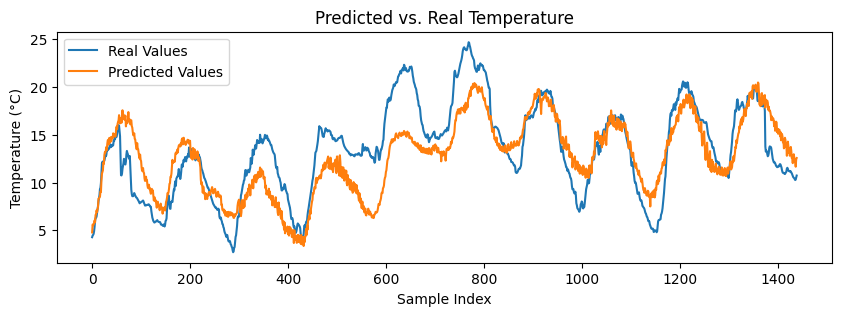

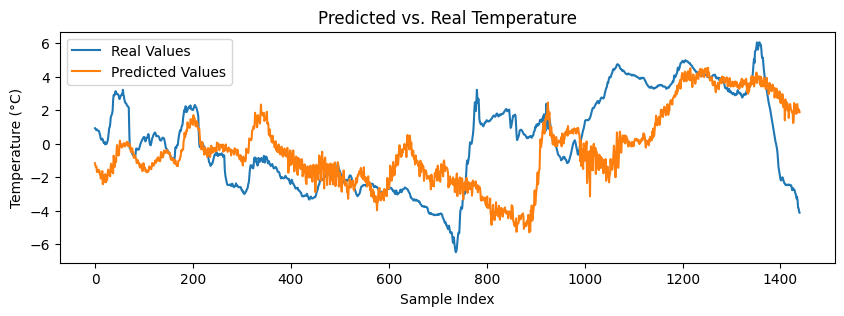

In [47]:
for start_index in [24, 24*6*4*29, 24*6*1*29,]:
    plot_predictions(test_dataset, model, 24*6*10, start_index)

## Bidirectional RNN

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 73s 85ms/step - loss: 56.9182 - mae: 5.6292 - val_loss: 12.7939 - val_mae: 2.7411
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 65s 80ms/step - loss: 12.5289 - mae: 2.7565 - val_loss: 10.8783 - val_mae: 2.5557
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 65s 79ms/step - loss: 10.5322 - mae: 2.5436 - val_loss: 10.3294 - val_mae: 2.5097
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 65s 79ms/step - loss: 9.4545 - mae: 2.3966 - val_loss: 9.7780 - val_mae: 2.4331
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 65s 79ms/step - loss: 8.8484 - mae: 2.3147 - val_loss: 9.4080 - val_mae: 2.3796
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 66s 80ms/step - loss: 8.3449 - mae: 2.2467 - val_loss: 9.2951 - val_mae: 2.3624
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 65s 79ms/step - loss: 7.9207 - mae: 2.1938 - val_loss: 9.3590 - val_mae: 2.3682
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 65s 80ms/step - loss: 7.5692 - mae: 2.1475 - val_loss: 9.4221 - val_mae: 2.3871
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━

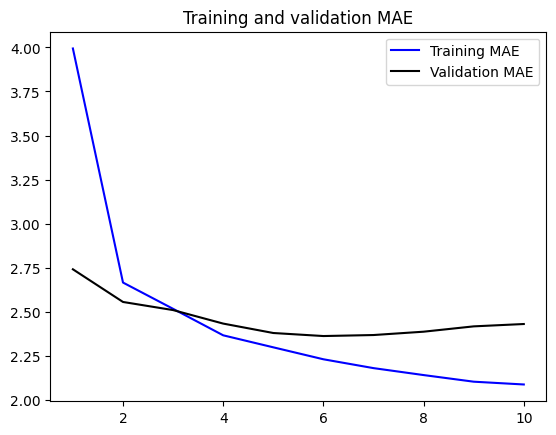

In [54]:
# Define model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("models/jena_bi.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10, # change
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("models/jena_bi.keras")

# Evaluate the model on the test set
val_loss= model.evaluate(val_dataset)
test_loss = model.evaluate(test_dataset)
train_loss = model.evaluate(train_dataset)
print(f"Train      MAE: {train_loss[1]:.2f}")
print(f"Validation MAE: {val_loss[1]:.2f}")
print(f"Test       MAE: {test_loss[1]:.2f}")


# Add results to the dataframe:
new_entry = {
    "Model Name" : "Bidirectional RNN",
    "Details" : "LSTM",
    "Train MAE" : train_loss[1],
    "Val MAE" : val_loss[1],
    "Test MAE" : test_loss[1],
}
results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)

# View and and save the dataframe:
print("Results:")
print(results_df)
results_df.to_csv("models/jena_results.csv", index=False)

# plot the training progress:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "b", label="Training MAE")
plt.plot(epochs, val_loss, "k", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

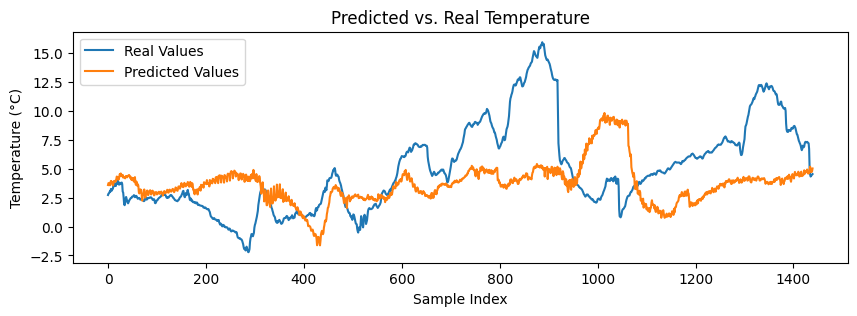

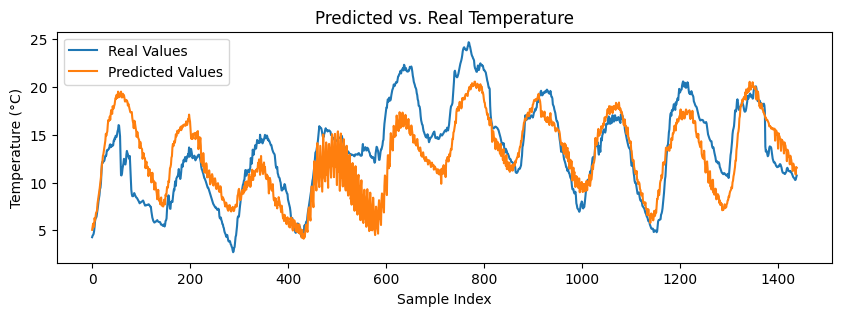

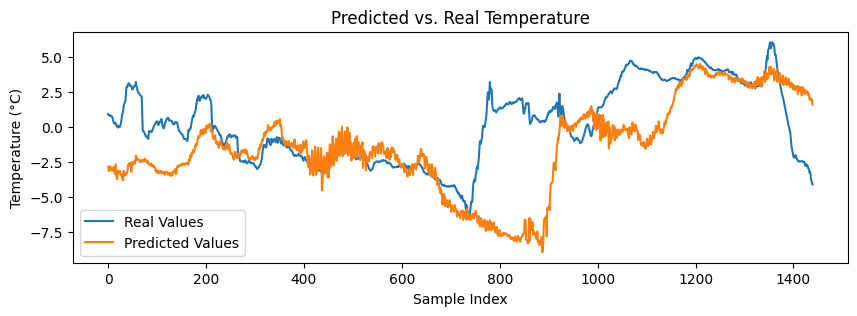

In [55]:
for start_index in [24, 24*6*4*29, 24*6*1*29,]:
    plot_predictions(test_dataset, model, 24*6*10, start_index)